## CM50268 / CM30322

## Coursework 1

# Exploring Bayesian Linear Regression

**Total Marks 30 (30% of overall unit grade).**

*Submission deadline: 8pm, Friday 7th March. Please submit your completed notebook file in Moodle.*

## Submission & Marking

For this coursework there are a number of places where you are expected to enter your own code. 
Every place you have to add code is  indicated by:

`#### **** YOUR CODE HERE **** ####`

There is also one place where you are asked to enter explanatory text (in Task 3b).
Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle**. 
The workbook you submit must be an `.ipynb` file, which is saved into the 
directory you're running Jupyter; alternatively you can download it from the menu above using 
`File -> Download`. Remember to save your work regularly
("Save Notebook" in the File menu, the icon of a floppy disk, or Ctrl-S);
the version you submit should have all code blocks showing the results (if any) 
of execution below them.

### Important!

**You should take care to avoid any suggestion of plagiarism in your submission.**
There is helpful information on "Academic Integrity" and, specifically, how to avoid plagiarism
on the University website: https://www.bath.ac.uk/library/help/infoguides/plagiarism.html

For this coursework, **you may use library code from specific sources only**: `numpy`, `scipy` and `matplotlib`. If you wish to use any alternative libraries, you are welcome to request this via the *Moodle* discussion forum.

Note that **the use of Generative AI is not permitted**.

## Overview of Coursework Tasks

This coursework focuses on implementing some of the requisite calculations and manipulations 
for applying Bayesian linear regression models as covered in Lectures 3&ndash;6.

Exercises include:

- computing the posterior distribution,
- computing the marginal likelihood,
- evaluating and choosing regularisation parameters,
- obtaining posterior mean models,
- calculation and exploitation of error-bars (the predictive standard deviation),
- ... some presentation of results.

The data is synthetic, derived from a "Gaussian" radial basis function (RBF) model. The model we will attempt
to fit is similarly a linearly-weighted set of "Gaussian" (RBF) basis functions. Our model, however,
will incorporate basis functions of different radius (width) than the generator. (In the second coursework
we will attempt to re-estimate this radius parameter.)
 
The training data has an important feature: *there are no observations from one
particular region of the data space*. 
One of the aims of the exercise (Task 3) is to see how this aspect 
impacts on the uncertainty of the model predictions.

There are three principal tasks, with varying marks. In summary here:

**Task 1:** Fit various Gaussian RBF-based linear models to the training data
using penalised least-squares (PLS), and visualise the results. (5 marks)

**Task 2:** Replicate the example "Occam's Razor" slide from Lecture 4
using the model and data here &mdash; that is, compute the train, validation and test set errors,
plus the marginal likelihood (the red dashed curve in the example slide), 
over a range of $\lambda$ (or $\alpha$) values. Identify and plot the best posterior mean model. (18 marks)

**Task 3:** Visualise the error-bars (predictive variance) alongside the best posterior mean model.
Explore how those error-bars might be usefully exploited in a real-world system where there is risk and reward.
(7 marks)

### "Advanced" Marks
**Please note!** Across assignments, there may be a small number of marks which are designated "advanced" marks.
These apply to sub-tasks which might be a little more technically demanding, and can optionally be skipped without interrupting the "flow" of an assignment.
In this particular coursework there are two "advanced" marks, and even if you ignore those questions, you can still obtain over 93% of the marks overall.

## Setup

### Support code

To get started, the code cell below imports the requisite standard Python modules.
**You may need to add some of your own `import` statements here too, although note the
restrictions specified earlier regarding library code use.**

In addition, there is a setup module `setup_cw1` specific to this lab. This module contains:

- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian "RBF" basis matrices for 
varying data sets,
- the function `error_rms` to simply calculate errors for a given target values 
$y$ and corresponding model output $f$,
- a function `plot_regression` to consistently plot data sets and curves etc,
- a couple of helper functions to optionally enable neat tabulation of outputs: `tabulate_locals` and
`tabulate_neatly`.

*You don't need to use the plotting and tabulation code* if you don't want to!

We also set some "constants" below: data set sizes and the generative noise standard deviation, 
which we fix at $\sigma=0.15$ for the entire exercise.

In [6]:
# Standard modules
import numpy as np

# Lab-specific support module
import setup_cw1 as setup

# Add your own imports here


# Data specification
N_train_full = 50  # Before any data is "masked out"
N_val_full = N_train_full
N_test = 1000
#
sigma = 0.15
sigma_2 = sigma ** 2

### Generate Data
We synthesise three data sets:
- training set of size $N_{train}=32$ (originally 50, but 18 points are "masked out") with added Gaussian random noise
with standard deviation $\sigma=0.15$,
- validation set of size $N_{val}=32$, again with added noise $\sigma=0.15$,
- test set of size $N_{test}=1000$ with **no noise** and **covers the full data space**.

A feature of the test set is that *it will include data from the region where there is no training data*.

**Note:** we assume for now that $\sigma$ is known and fixed.

In [8]:
# Data - create generator instance, and synthesise 3 sets from
# an RBF model using 10 basis functions and no bias
#
radius_gen = 1.00  # Generative basis radius or width
train_mask = [3, 6]  # The range where there will be no data
generator = setup.DataGenerator(r=radius_gen, noise=sigma, mask=train_mask)
#
x_train, y_train = generator.get_data('TRAIN', N_train_full, mask_out=True)
x_val, y_val = generator.get_data('VALIDATION', N_val_full, mask_out=True)
x_test, y_test = generator.get_data('TEST', N_test, mask_out=False)

N_train = 32
Empirical σ_train = 0.150
N_validation = 32
Empirical σ_validation = 0.150
N_test = 1000


### Generate Basis for Linear Model
For our linear model, we use as many functions as data points (a "complete" basis), 
comprising $N-1$ equally-spaced Gaussian functions of the form:
 
$$\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}.$$
 
plus a fixed "bias" or "offset". (The synthesised data was based on a different set of basis functions and did *not* use a bias.)

The model basis function 'width' (length scale) parameter $r$ is set to 0.75. (This is narrower than the width
used to generate the data.)

If we call `evaluate` on the basis generator, 
we get a $N\times{}M$ matrix $\mathbf{\Phi}$ returned, where each column / row contains 
the output of each basis function on each data point respectively: that is, 
$\mathbf{\Phi}_{nm} = \phi_m(x_n)$. The use of a bias means the first column contains 
simply a fixed value of one. 

For the training set, this matrix $\mathbf{\Phi}$ will be $32 \times 32$,
whereas for the test set it will be $1000 \times 32$.

For illustration, the data and the underlying "ground-truth" are shown below, 
with basis functions overlaid. Some local variables are also tabulated, just to summarise the key variables.
(This can also be a useful "sanity check" in longer notebooks.)

Local Variables Check

Variable,Value
N_train,32
N_val,32
N_test,1000
sigma,0.15
sigma_2,0.0225
M,32
radius_gen,1
radius_model,0.75


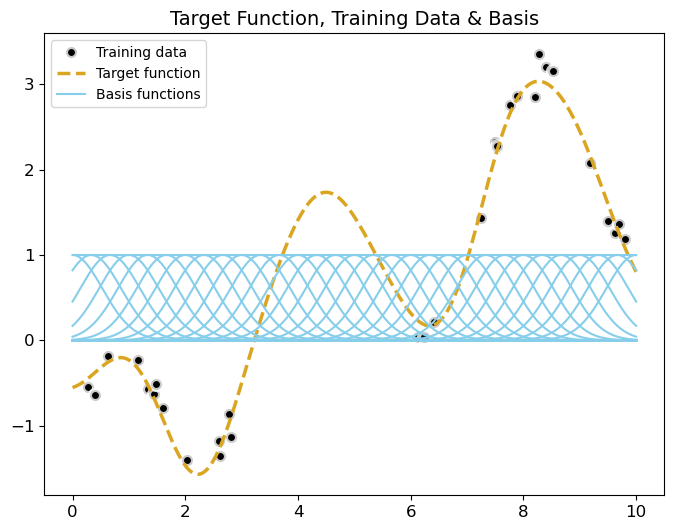

In [10]:
# Basis - create generator instance and compute the basis matrices for all 3 data sets
# Note that because we use a "bias" function, we need N-1 Gaussians to make the
# basis "complete" (i.e. for M=N)
#
N_train = len(x_train)
N_val = len(x_val)
radius_model = radius_gen * 0.75
centres = np.linspace(generator.x_min, generator.x_max, N_train - 1)
basis = setup.RBFGenerator(centres, width=radius_model, bias=True)
M = basis.M
#
PHI_train = basis.evaluate(x_train)
PHI_val = basis.evaluate(x_val)
PHI_test = basis.evaluate(x_test)
#
interest = ["N_train", "N_val", "N_test", "sigma", "sigma_2",
            "M", "radius_gen", "radius_model"]
setup.tabulate_locals(locals(), interest)
#
setup.plot_regression(x_train, y_train, x_test, y_test, basis_test=PHI_test,
                      title="Target Function, Training Data & Basis", legend=True)


# Task 1: Fitting Penalised Least Squares Models
**5 marks for this task in total.**

## Task 1a
*2 marks overall*

#### Implement penalised least squares fitting (2 marks)

Write a function `fit_pls` (its signature is defined in the cell below) to fit a linear model with basis matrix `PHI_train` to the training data `y_train` for a given value of regularisation parameter $\lambda$. It should return the weight vector $\mathbf{w}_{PLS}$ that minimises the penalised least squares error.

You may find the functions `np.linalg.lstsq` and/or `np.linalg.inv` applicable.

For maximum marks, the ideal solution will treat $\lambda=0$ case differently to $\lambda>0$.

In [12]:
## FIT_PLS
##
def fit_pls(PHI, y, lam):
    #
    #### **** YOUR CODE HERE **** ####
    M = PHI.shape[1]  # Number of features

    if lam == 0:  # Standard least squares
        w, _, _, _ = np.linalg.lstsq(PHI, y, rcond=None)  # Find w that minimizes the error
    elif lam > 0:  # Penalized least squares
        I = np.eye(M)
        # Use np.linalg.solve for better numerical stability
        w = np.linalg.solve(PHI.T @ PHI + lam * I, PHI.T @ y)
    else:
        raise ValueError("Lambda should be positive term")
    return w
    #


## Task 1b
*3 marks overall*

#### Implement a prediction assessor (1 mark)

Write a function `assess_predictor` that does the following:

- fits the model to the data for a given value of lambda using `fit_pls`
- computes the fitted model's predictions `f_test` on the *test set* (you will need to multiply the
  relevant $\mathbf{\Phi}$ by $\mathbf{w}_{PLS}$)
- plots the training data, target function (test data) and the predictions (using `plot_regression`)
- returns the RMS training and test errors

#### Visualise fits for three values of λ (1 mark)

Using the function you have just written, add a few lines of code in the second cell below
to plot three graphs for values of $\lambda$ in \[ 1e-9, 0.05, 25\]. In each graph (appropriately labelled by $\lambda$),
your `assess_predictor` function should show:
- the training data (`x_train` and `y_train` as points)
- the underlying generating function (by plotting `x_test` and `y_test` as a line)
- your fitted function `f_test` at points `x_test` (as a line)

#### Tabulate PLS errors (1 mark)

Output a table, showing the RMS error for both train and test sets for all three values of $\lambda$.

The supplied function `plot_regression` should do nearly all the plotting work for you, but please add an informative title.
(You do not need to show the basis.)

You should find that the first $\lambda$ value over-fits, the second is "about right" 
(but only where there is data!) and the third under-fits.

In [14]:
## FITTING & GRAPHING FUNCTION
#  
def assess_predictor(model_rbf, lamb, x__train, y__train, x__test, y__test):
    #
    #### **** YOUR CODE HERE **** ####
    PHI_train = model_rbf.evaluate(x__train)
    PHI_test = model_rbf.evaluate(x__test)
    
    w = fit_pls(PHI_train, y__train, lamb)
    f_train = PHI_train @ w 
    f_test = PHI_test @ w 
    
    setup.plot_regression(
    x__train, y__train,  # Consistent variable names
    x__test, y__test,
    y_predict = f_test,
    title=f"Model Predictions (lambda = {lamb})",
    legend=True
)
    error_train = setup.error_rms(y__train, f_train)
    error_test = setup.error_rms(y__test, f_test)
    #
    return error_train, error_test


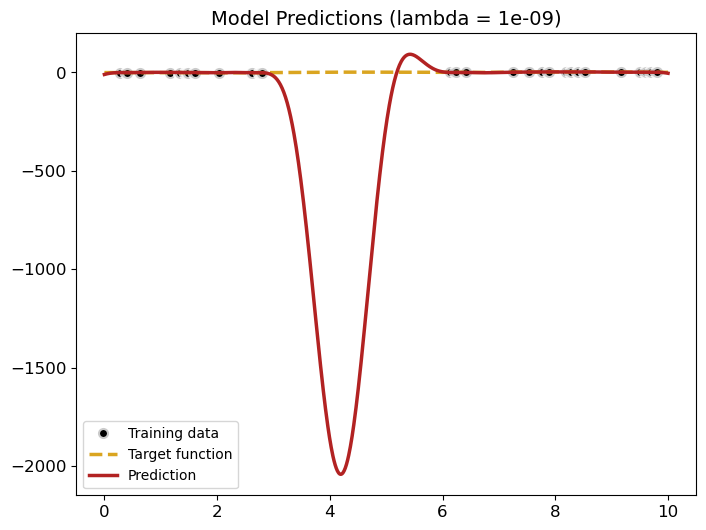

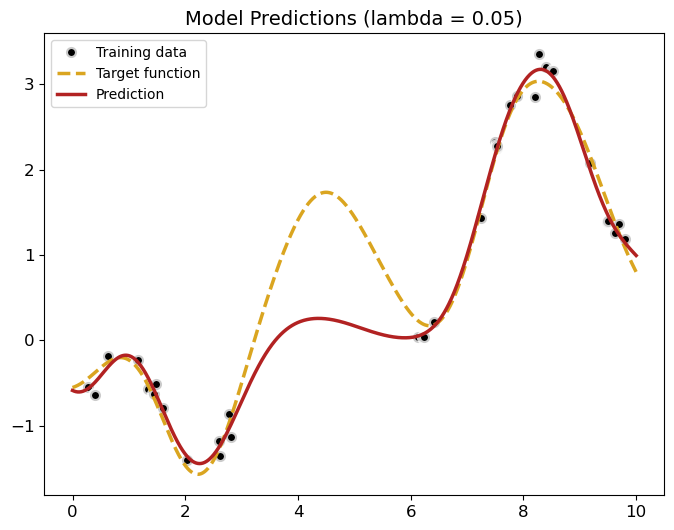

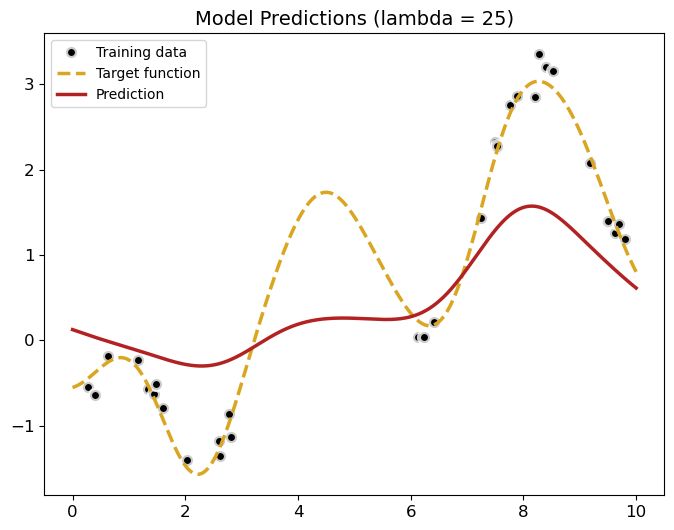

In [15]:
# Add code to plot the requested graphs for lambda_value=1e-9, 0.05 and 25 respectively,
# while simultaneously compiling a table of errors
#
#### **** YOUR CODE HERE **** ####

lambda_values  = [1e-9, 0.05, 25]
errors = []
for val in lambda_values:
    rms_train, rms_test = assess_predictor(basis, val, x_train, y_train, x_test, y_test)
    errors.append([val, rms_train, rms_test])
#


In [16]:
# Output your table here
#
#### **** YOUR CODE HERE **** ####
from tabulate import tabulate
print(tabulate(errors, headers=["Lambda", "Train RMS Error", "Test RMS Error"], floatfmt=".6f"))
#


   Lambda    Train RMS Error    Test RMS Error
---------  -----------------  ----------------
 0.000000           0.059579        570.746921
 0.050000           0.107982          0.573423
25.000000           0.890223          0.897683


# Task 2 : Bayesian Modelling & the Marginal Likelihood
**18 marks for this task in total.**

## Task 2a
*3 marks overall*

#### Compute the posterior distribution (3 marks)

Write a function `compute_posterior` to compute the posterior mean $\mathbf{\mu}$ and 
covariance $\mathbf{\Sigma}$ for the Bayesian linear regression model with 
basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and 
$\sigma^2$.

Verify the consistency of your posterior code with `fit_pls` by comparing 
the outputs `w` and `Mu` (they should be the same), remembering to take account of the fact 
that $\alpha \equiv \lambda/\sigma^2$.

As well as defining your `compute_posterior` function below, 
append a few lines of code underneath 
which show your consistency check for $\lambda=0.01$.

In [18]:
## POSTERIOR
##

def compute_posterior(PHI, y, alpha, sigma_squared):
    #
    #### **** YOUR CODE HERE **** ####
    M = PHI.shape[1]
    I = np.eye(M)
    #w = np.linalg.solve(PHI.T @ PHI + lam * I, PHI.T @ y)
    post_mean = np.linalg.solve(PHI.T @ PHI + alpha * sigma_squared * I, PHI.T @ y)
    #post_cov = sigma_squared * np.linalg.inv(PHI.T @ PHI + sigma_squared * alpha * I)
    post_cov = sigma_squared * np.linalg.solve(PHI.T @ PHI + alpha * sigma_squared * I, np.eye(M))
    return post_mean, post_cov
    #

# check consistency
#
#### **** YOUR CODE HERE **** ####
result =[]
lambda_val = 0.01

alpha = lambda_val / sigma_2
w_pls = fit_pls(PHI_train, y_train, lambda_val)
mu_posterior, _ = compute_posterior(PHI_train, y_train, alpha, sigma_2)
difference = np.linalg.norm(w_pls - mu_posterior)

result.append([
        lambda_val,  
        np.array2string(w_pls, precision=10, suppress_small=True), 
        np.array2string(mu_posterior, precision=10, suppress_small=True), 
        f"{difference:.10f}" 
    ])
# Print the result in a tabular format
print(tabulate(result, headers=["Lambda", "Weights (PLS)", "Posterior Mean", "Difference"], floatfmt=".10f"))
#


      Lambda  Weights (PLS)      Posterior Mean       Difference
------------  -----------------  -----------------  ------------
0.0100000000  [[ 0.3886191532]   [[ 0.3886191532]   0.0000000000
               [-0.8334829751]    [-0.8334829751]
               [-0.3961233158]    [-0.3961233158]
               [ 0.1935216407]    [ 0.1935216407]
               [ 0.0689709867]    [ 0.0689709867]
               [-0.239392631 ]    [-0.239392631 ]
               [-0.2779962372]    [-0.2779962372]
               [-0.5377841384]    [-0.5377841384]
               [-0.7580408016]    [-0.7580408016]
               [-0.4913654919]    [-0.4913654919]
               [-0.1490094936]    [-0.1490094936]
               [-0.053536681 ]    [-0.053536681 ]
               [-0.0536543696]    [-0.0536543696]
               [-0.0336167429]    [-0.0336167429]
               [-0.0149390746]    [-0.0149390746]
               [-0.0282358021]    [-0.0282358021]
               [-0.1094557211]    [-0.1094557211]
     

## Task 2b
*3 marks overall*

#### Compute the marginal likelihood (2 marks)

Write a function `compute_log_marginal` to compute the *logarithm* of
the marginal likelihood for the Bayesian linear regression model with basis matrix 
$\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

The necessary equation(s) may be found in the slides / notes corresponding to Lecture 4
("Marginalisation & Occam's Razor"):
 
$$p(\mathbf{y}|\alpha, \sigma^2) = 
(2 \pi)^{-\frac{N}{2}} |\sigma^2 \mathbf{I} + 
\alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top}|^{-\frac{1}{2}} 
\exp\{ -\frac{1}{2} \mathbf{y}^{\top} 
(\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top})^{-1} \mathbf{y}  \}.$$

**Important:** for numerical reasons, when computing the logarithm of a probability density,
always compute the logarithmic form directly (whether in terms of your own Python code or
via a library such as `stats.multivariate_normal.logpdf`).
**Never** compute the pdf and then call `np.log`!

In practice, you should not have numerical issues using 
`stats.multivariate_normal.logpdf` (this can happen if you experiment 
with larger data sets, in which case you may wish to look at the `allow_singular` argument.)
You can also code up your own calculation "manually" without use of library code (in two different ways).


#### Woodbury Identity (advanced) (1 mark)

**Advanced**: As an alternative to `stats.multivariate_normal.logpdf`, there is a more
robust way of calculating the marginal likelihood directly, which you may wish to explore
if you are confident with linear algebra and matrix identities.

**Note:** this advanced mark is
in addition to that above &mdash; you should also provide a "standard" implementation of `compute_log_marginal`
to obtain full marks for Task 2b.

The "straightforward" way to calculate the marginal likelihood is to compute 
the NxN covariance matrix and then call the `logpdf` function.
As a result, this will imply an expensive, and potentially numerically troublesome, 
inversion of an N x N matrix (inside `logpdf`). This works OK, but in general we can do better.

To gain the extra advanced mark, you would need to re-phrase the straightforward way
in terms of the inversion, and determinant, of an M x M matrix. 
Since matrix inversion scales cubically with the matrix size (M or N),
this is computationally a lot cheaper in the usual case where N >> M,
and more importantly, numerically much more robust.

Slightly confusingly in this exercise here, N = M, so it doesn't appear 
to make any difference. However, in more general modelling situations, 
M would be a lot smaller than N, so it would be an important thing to do. 
In terms of re-phrasing the inversion as M x M, you may wish to look at 
the "Woodbury Identity", which crops up regularly in data science.
There is an equivalent identity for determinants too.

In [20]:
## MARGINAL LIKELIHOOD
##
from scipy import stats

def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    N, M = PHI.shape
    
    C = s2 * np.eye(N) + (1/alph) * PHI @ PHI.T
    log_marginal = stats.multivariate_normal.logpdf(y.flatten(), mean=np.zeros_like(y.flatten()), cov=C)

    return log_marginal
    
    #


In [21]:
## MARGINAL LIKELIHOOD (ADVANCED VERSION - OPTIONAL)
##

import numpy as np
from scipy.optimize import minimize_scalar
from scipy.linalg import solve

def compute_log_marginal_advanced(PHI, y, alph, s2):
  
    N, M = PHI.shape

    # Compute the M x M matrix for Woodbury Identity
    A = (1 / alph) * np.eye(M) + (1 / s2) * PHI.T @ PHI

    # Use numerically stable determinant computation
    sign, log_det_A = np.linalg.slogdet(A)
    log_det_C = N * np.log(s2) + log_det_A

    # Avoid direct inversion
    A_inv = np.linalg.solve(A, np.eye(M))

    # Compute quadratic term using Woodbury Identity
    C_inv_y = (1 / s2) * y - (1 / s2**2) * PHI @ A_inv @ PHI.T @ y
    quadratic_term = y.T @ C_inv_y

    # Compute log marginal likelihood
    log_marginal = - 0.5 * (N * np.log(2 * np.pi) + log_det_C + quadratic_term)

    # Ensure the output is a scalar
    return log_marginal.item()  if np.ndim(log_marginal) > 0 else log_marginal


## Task 2c
*9 marks overall*

In the cells below, write some code to produce a similar figure to that below (taken from the lecture) for the
Gaussian RBF basis and the data set(s) defined above.

<img src="slide15.png" alt="Slide 15 from Lecture 5"
 style="width: 512px;margin-left:16mm;"/>

In more detail, over a range of $\lambda$ (or equivalent $\alpha=\lambda/\sigma^2$) values, 
you should do the following:

#### Compute the relevant errors (1 mark)

Compute the train, validation and test set errors for
the penalised least-squares model (use your `fit_pls` to fit it, and the supplied `error_rms`
in 'setup_cw1' to calculate the error).

#### Compute the (negative log) marginal likelihood (2 marks)

Also compute the *negative* log marginal likelihood using the function just written,
for the training data set *and a data set which combines both the training and validation data*.

#### Plot the curves (3 marks)

Plot **all these curves on the same graph**, noting that the vertical axis for
the errors is different for that of the negative log marginal likelihood (see hint below),
and the horizontal axis, while shared, requires careful translation between λ and α.

Credit will be given for a clearly rendered graph, with sensible axis scaling.

Note that it's *not* essential to plot the vertical lines which connect the curves.

#### Find minimum points and tabulate test errors (2 marks)

In addition to plotting the graph, add code to compute,
and output (using `print` or `tabulate_neatly`), the *test error* corresponding to
the minimum point on:
- the test error curve itself,
- the validation curve,
- the negative marginal likelihood curve (on the training data),
- the negative marginal likelihood curve (on combined training and validation data).

#### Find the best α value (1 mark)

Calculate a value of `best_alpha`, which is the value of $\alpha$ that minimises
the negative marginal likelihood curve (on *combined* training and validation data).

### Notes

For easiest interpretation, please define your $\lambda$ range 
logarithmically (**base 10**) and **fix the range between -6 and 4**.

First use `np.linspace(begin,end,steps)` to create equally spaced values `v`, 
then specify `lam = 10**v`. Please fix the `steps` value as 100.

You should find that your graph has a similar qualitative form to the above figure, 
although there will be one extra curve and the test error curve will be higher above the
training/validation curves.

### Hints

- You can create a new $y$-axis on the same plot, which shares the $x$-axis, 
using `plt.gca().twinx()`.
- Remember that $\alpha=\lambda/\sigma^2$. If you don't rescale appropriately, 
the marginal likelihood curve will not be correctly aligned with the error curves 
and your minimum point will be incorrect! 😟

In [23]:
#
#### **** YOUR CODE HERE **** ####
#

# Calculate the error for the train, test and validation sets and
# the negative log marginal-likelihood on the train set and combined
# train and validation sets ... all for a range of lambda
log_lambda_values = np.linspace(-6, 4, 100)  
lambda_values = 10 ** log_lambda_values  
alpha_values = lambda_values / sigma_2 

# Precompute train+val sets to avoid recomputation
PHI_train_val = np.concatenate((PHI_train, PHI_val), axis=0)
y_train_val = np.concatenate((y_train.flatten(), y_val.flatten()))

# Preallocate arrays for performance
train_errors = np.zeros(len(lambda_values))
val_errors = np.zeros(len(lambda_values))
test_errors = np.zeros(len(lambda_values))
neg_log_marg_train = np.zeros(len(lambda_values))
neg_log_marg_train_val = np.zeros(len(lambda_values))

# Iterate over lambda values
for i, alpha in enumerate(alpha_values):
    #alpha = lam / sigma_2  
    lam = alpha * sigma_2
    # Fit the model using fit_pls
    w = fit_pls(PHI_train, y_train, lam)
    # Compute errors
    train_errors[i] = setup.error_rms(y_train, PHI_train @ w)
    val_errors[i] = setup.error_rms(y_val, PHI_val @ w)
    test_errors[i] = setup.error_rms(y_test, PHI_test @ w)

    # Compute Negative Log Marginal Likelihood
    neg_log_marg_train[i] = - compute_log_marginal(PHI_train, y_train, alpha, sigma_2)
    neg_log_marg_train_val[i] = - compute_log_marginal(PHI_train_val, y_train_val, alpha, sigma_2)


Minimum Points & Test Errors

Type of RMS Error,Corresponding RMS Error Value
Minimum Test Error,0.571599
Minimum Validation Error,0.588476
Minimum Neg Log Marg Likelihood (Train),0.574858
Minimum Neg Log Marg Likelihood (Train+Val),0.572497


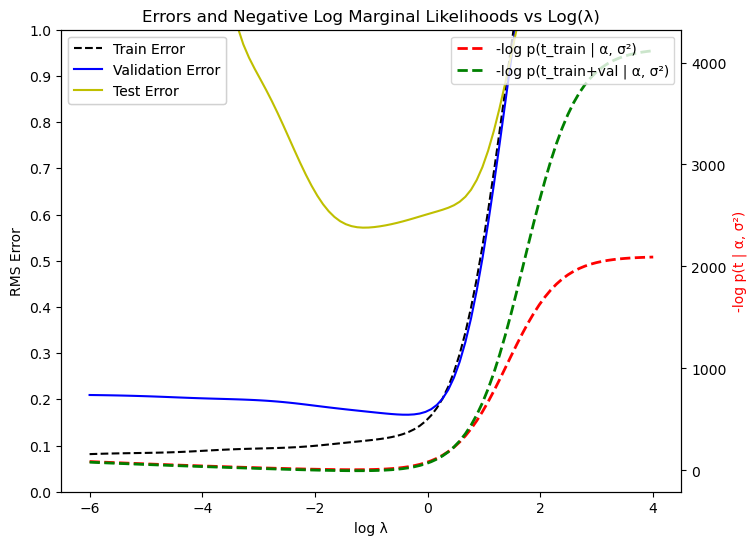



Best α value (minimizing negative marginal likelihood on Train + Validation): 2.484805


In [24]:
# PLEASE PLOT ALL THE CURVES IN THE SAME FIGURE

# Print out (or tabulate) the test error corresponds to the minimum point on (1) the test error curve itself,
# (2) the validation curve, and (3, 4) the negative marginal-likelihood curves.

# Find indices of minimum values
min_test_index = np.argmin(test_errors)
min_val_index = np.argmin(val_errors)
min_neg_log_marg_train_index = np.argmin(neg_log_marg_train)
min_neg_log_marg_train_val_index = np.argmin(neg_log_marg_train_val)

# Get corresponding test errors
min_test_error = test_errors[min_test_index]
min_val_test_error = test_errors[min_val_index]
min_neg_log_marg_train_test_error = test_errors[min_neg_log_marg_train_index]
min_neg_log_marg_train_val_test_error = test_errors[min_neg_log_marg_train_val_index]

# Prepare table data
results = [
    ["Minimum Test Error", min_test_error],
    ["Minimum Validation Error", min_val_test_error],
    ["Minimum Neg Log Marg Likelihood (Train)", min_neg_log_marg_train_test_error],
    ["Minimum Neg Log Marg Likelihood (Train+Val)", min_neg_log_marg_train_val_test_error],
]

# Print table using tabulate_neatly
setup.tabulate_neatly(results, headers=["Type of RMS Error", "Corresponding RMS Error Value"], title="Minimum Points & Test Errors")
print("\n")
#
#### **** YOUR PLOTTING CODE HERE **** ####
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


# Create the first y-axis (for errors)
fig, ax1 = plt.subplots(figsize=(8, 6)) 
ax1.set_xlabel("log λ")
ax1.set_ylabel("RMS Error", color="black")
ax1.set_ylim(0.0, 1.0)  # Adjusted for better visualization between [0,1]
ax1.set_yticks(np.arange(0.0, 1.1, 0.1))

# Plot Train, Validation, and Test Errors
ax1.plot(log_lambda_values, train_errors, 'k--', label="Train Error")  # Black Dashed Line
ax1.plot(log_lambda_values, val_errors, 'b-', label="Validation Error")  # Blue Solid Line
ax1.plot(log_lambda_values, test_errors, 'y-', label="Test Error")  # Yellow Solid Line
ax1.tick_params(axis="y", labelcolor="black")

# Create the second y-axis (for Negative Log Marginal Likelihood)
ax2 = plt.gca().twinx()  
ax2.set_ylabel("-log p(t | α, σ²)", color="red")  
#ax2.set_ylim(min(neg_log_marg_train) - 1, max(neg_log_marg_train_val) + 1)  # Auto-scale
ax2.autoscale(enable=True, axis="y")  # Auto-scale the y-axis

# Plot Negative Log Marginal Likelihood with markers for better visibility
ax2.plot(log_lambda_values, neg_log_marg_train, 'r--', linewidth=2, label="-log p(t_train | α, σ²)")  # **Red Dashed**
ax2.plot(log_lambda_values, neg_log_marg_train_val, 'g--', linewidth=2, label="-log p(t_train+val | α, σ²)")  # Green Dashed

# Title and Grid
plt.title("Errors and Negative Log Marginal Likelihoods vs Log(λ)")

# Combine legends from both axes
ax1_legend = ax1.legend(loc="upper left")
ax2_legend = ax2.legend(loc="upper right")
ax1.add_artist(ax1_legend)  # Ensure ax1 legend stays

plt.show()



###########
# Find the index where the negative marginal likelihood (Train + Validation) is minimized
best_alpha_index = np.argmin(neg_log_marg_train_val)

# Extract the corresponding alpha value
best_alpha = alpha_values[best_alpha_index]
#print(f"lambda:{lambda_values[best_alpha_index]:.6f}")
# Print the best alpha value
print("\n")
print(f"Best α value (minimizing negative marginal likelihood on Train + Validation): {best_alpha:.6f}")

#


## Task 2d
*3 marks overall*

#### Evaluate the posterior mean predictor (2 marks)

Using the best value of $\alpha$ according to the marginal likelihood as found in Task 2c 
above, call `compute_posterior` to find the posterior mean weight vector $\mu$ and 
use this to compute the posterior mean predictor at all the test points 
`x_test`. 

#### Visualise the predictor (1 mark)

Then, similar to Task 1b, using the `plot_regression` function, plot on the same axes:
1. the training data (`x_train` and `y_train` as points),
2. the underlying generating function (by plotting `x_test` and `y_test` as a line),
3. the posterior mean predictor function you just calculated.

You should find that the predictor is a pretty good fit to the underlying 
generating function *where there was data in the training set*. 
We can't expect the model to make good predictions in the "gap" 
where it has not seen any training data (unless it gets lucky!).

In [26]:
# Code to calculate posterior mean weights and corresponding predictor
#### **** YOUR CODE HERE **** ####
# Compute posterior mean weight vector using best_alpha
posterior_mean, posterior_cov = compute_posterior(PHI_train, y_train, best_alpha, sigma_2)

# Compute the posterior mean predictor at all test points
posterior_predictor = PHI_test @ posterior_mean


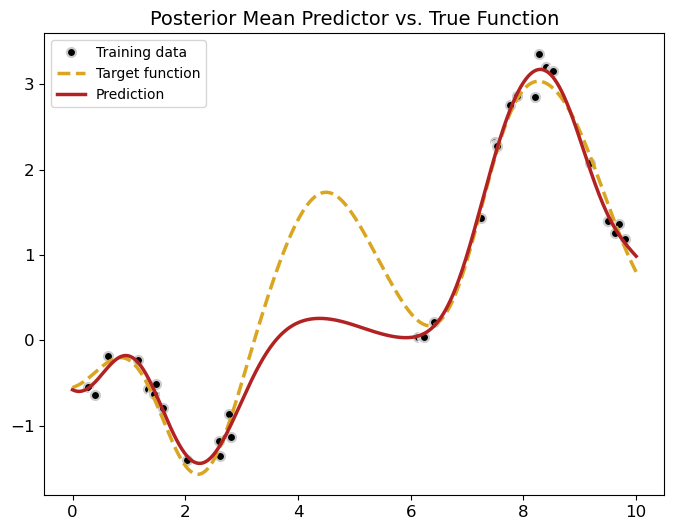

In [27]:
# Visualise the predictor
#
#### **** YOUR PLOTTING CODE HERE **** ####
setup.plot_regression(
    x_train, y_train,
    x_test, y_test,
    y_predict = posterior_predictor,
    title="Posterior Mean Predictor vs. True Function",
    legend=True
)
#


# Task 3: Predictive Variance and Error Bars <a name="task3"></a>
**7 marks for this task in total.**

## Task 3a
*2 marks overall*

#### Compute the predictive variance and then plot the "error-bars" (2 marks)

Remember that a "prediction" of $y_\ast$ at a particular $x_\ast$ in the Bayesian sense is not a single value, but actually a
*distribution* over possible values that a new datum $y_\ast$ (sampled at $x_\ast$) might take,
based on the model definition and the parameter settings. That
distribution encapsulates the inevitable uncertainty in prediction, taking account of both the data noise
variance (which can't be avoided) and the uncertainty in estimating the weights (which will decrease with more training data).
Given our model choices, we have a Gaussian predictive distribution at each $x$,
and the graph you plotted above (in Task 2d) shows just the *mean* of the distribution at each point.

Repeat the graph above (Task 2d), for the same "best" predictor, but this time also
compute the predictive variance at each point in `x_test`, and use these values to overlay 
"error bars" on the plot.

### Notes

The predictive variance can be computed from the posterior covariance matrix
$\mathbf{\Sigma}$ in conjunction with the `PHI_test` basis matrix, along with the noise variance $\sigma^2$.
To plot the "error bars", you will need to compute the predictive *standard deviation* at each test point &mdash;
in other words, the square-root of the predictive variance.

- By "error bars" we usually mean some chosen multiple of the predictive standard deviation; please
opt for +/- **one standard deviation** here,
- You'll need to compute this for every $x$ &mdash; you can do this with a loop, but there is also
an efficient way to do it with matrix and vector operations
- To compute the predictive variance at `x_test`, you'll need the matrix `PHI_test`,
- The matplotlib function `plt.fill_between` is a handy utility for plotting error bars, 
but you may also wish to look at the functionality in `plot_regression`,
- If your calculations are correct, you should expect to see much larger error bars in the gap
where there is no data.

In [29]:
# Compute the predictive variance
#
#### **** YOUR CODE HERE **** ####
# Compute predictive variance
predictive_variance = np.diag(PHI_test @ posterior_cov @ PHI_test.T) + sigma_2

#Compute predictive standard deviation
predictive_std = np.sqrt(predictive_variance)


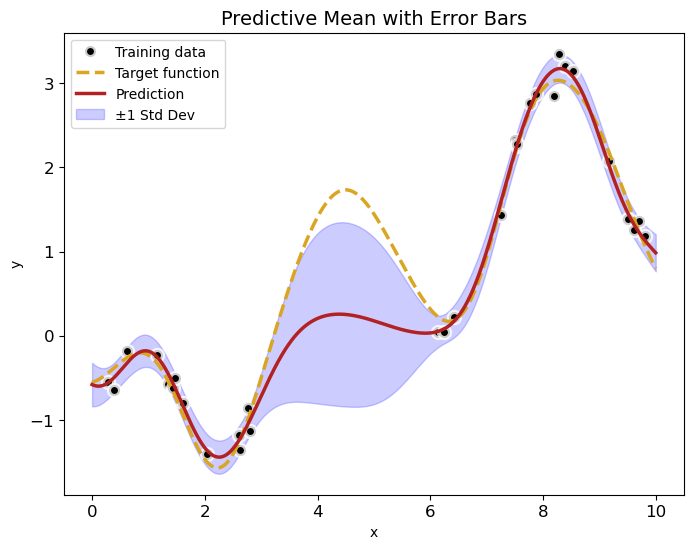

In [30]:
# Plot the error bars
#
#### **** YOUR PLOTTING CODE HERE **** ####

# Flatten arrays for plotting
x_test = x_test.flatten()
posterior_predictor = posterior_predictor.flatten()
predictive_std = predictive_std.flatten()  

# Plot regression results
setup.plot_regression(
    x_train, y_train, 
    x_test, y_test, 
    y_predict=posterior_predictor,  
    title="Predictive Mean with Error Bars"
)

# Overlay error bars
plt.fill_between(
    x_test, 
    posterior_predictor - predictive_std, 
    posterior_predictor + predictive_std, 
    color='blue', alpha = 0.2, label='±1 Std Dev'
)

# Labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
#


## Task 3b
*5 marks overall*

This is a more open-ended question, with an opportunity to think a little creatively.

Imagine you had built the above model for inclusion within some real-world system where 
it was desired to make accurate predictions at the 1,000 test points. For this exercise, you
can assume there is no data noise when deployed, and the only predictive uncertainty is due
to the weights of the trained model.

The "real-world system" is such that there are costs and rewards associated with each prediction:

- for each absolute error of `threshold=0.15` or less, the model is rewarded with £10
- for each absolute error of greater than `threshold`, there is a cost of £20

**Key feature of the "system":** *You may decline to make a prediction for a given data point*, based on the knowledge of $x$.
If you do decline to make a prediction, there is no cost (or reward).

### Devise an Algorithm Which Chooses When to Predict (and When to Decline)
*Without knowledge of the test set*, devise an algorithm that aims to maximise your *expected* earnings.
That is, an algorithm that decides, given an arbitrary $x$, whether to predict $y$ or whether to decline.
This can only be an approximate maximisation (remember, "all models are wrong"), but, given the model,
there is a principled way to make a decision whether to predict or decline, given the cost and reward
specification.

Specifically, where indicated in the below cells (and detailed further below), do the following four things:

1. Explain your approach
2. Implement your algorithm
3. Evaluate it and tabulate results
4. **Advanced:** Visualise its decision-making

#### Explain your algorithm (2 marks)

Write a short explanation of your approach in the "Explanation of Approach" markdown cell.

#### Implement your algorithm (1 mark)

Provide the necessary decision code for your algorithm in the first code cell below.

#### Evaluate your approach and tabulate some statistics (1 mark)

In the second code cell below, apply your algorithm to the 1,000 (noiseless) test points `x_test` and tabulate:

- The number of predictions (out of 1,000) made
- The number that were rewarded for being within threshold
- The number that were charged for being outside the threshold
- The percentage of predictions made that were rewarded
- Your total earnings

You should be able to make as much as £5,000 (or thereabouts, without cheating!).
If your algorithm is over-confident and makes too many predictions, you may do poorly due to incurring many costs. Alternatively, if your algorithm is too conservative and declines to predict too often, you may do poorly due to not earning enough rewards.

#### Visualise the operation of your algorithm (advanced) (1 mark)

**Advanced:** Plot a graph which illustrates where your algorithm chooses to predict and where it chooses to decline.
More specifically, you should show:
- the target function (test points `x_test` and `y_test` as a line)
- your predictor (posterior mean)
- the error-bars, but only where the algorithm chooses to predict, and in one particular colour of your choosing
- the error-bars, this time only where the algorithm chooses to decline, and in a different colour of your choosing
- a helpful legend
- Optionally: the training data


### Explanation of Approach (*Your Answer Here*)

My algorithm aims to maximize expected earnings by deciding when to make a prediction and when to decline based on predictive uncertainty.

To begin, I defined a function called "predict_or_decline", which checks if the predictive variance (pred_var) is less than 0.10 . If the variance is below 0.10 , the model is highly confident and consistent enough to make a prediction ("predict"). Otherwise, the model declines to avoid potential penalties ("decline"). I  have choosen 0.10 for ensuring my model is highly confident to make predictions, and avoid too many declines.

The algorithm evaluates the performance of model by considering the following inputs:

Input data (x_test)
Target values (y_test)
Model's posterior mean predictions (post_mean_pred)
Predictive variances (pred_var)
Fixed threshold, reward, and cost values

For each test data point i, the function "predict_or_decline" is called with the corresponding predictive variance (pred_var[i]) and the threshold. The decision is either to predict or decline.

If the model decides to predict, the following set of actions occur:

The number of predictions made (num_predictions) is incremented.
The absolute error between the model's prediction (post_mean_pred[i]) and the true value (y_test[i]) is calculated.
If the absolute error is within the threshold (≤ 0.15), the prediction is considered accurate, and the model earns a reward of £10. The count of rewards (num_rewards) is incremented.

If the absolute error exceeds the threshold (> 0.15), the prediction is not accurate enough, and the model incurs a cost of £20. The count of costs (num_cost) is incremented.

In summary, the approach strives to balance the trade-off between earning rewards and avoiding costs by making predictions only when the model is confident. By doing so, it aims to maximize total earnings while minimizing penalties.


After evaluating the model on the test set, the algorithm summarizes key statistics:

"Total Number of Predictions Made", "Number of Predictions Rewarded", "Number of Predictions Charged", "Percentage of Predictions Rewarded", and finally "Total Earnings", that is, the total monetary earnings, accounting for both rewards and penalties.

The results are presented in a well-formatted table using the tabulate function, providing a clear view of the model's performance and earnings.


In [33]:
# Implement your algorithm here
#
# Use these fixed values
threshold = 0.15
reward_under = 10
cost_above = 20

#### **** YOUR ALGORITHM CODE HERE **** ####
# Decision function: Predict or Decline based on variance
def predict_or_decline(pred_var):
    return 'predict' if pred_var < 0.10 else 'decline'

# Evaluation function
def evaluate_predictions(x_test, y_test, post_mean_pred, pred_var, threshold=0.15, reward_under=10, cost_above=20):
    num_predictions = 0
    num_rewards = 0
    num_cost = 0
    total_earnings = 0

    for i in range(len(x_test)):
        decision = predict_or_decline(pred_var[i])
        if decision == 'predict':
            num_predictions += 1
            abs_error = np.abs(post_mean_pred[i] - y_test[i])  # Could be an array

            if abs_error < threshold:
                num_rewards += 1
                total_earnings += reward_under
            else:
                num_cost += 1
                total_earnings -= cost_above

    results = {
        'Number of Predictions Made': num_predictions,
        'Number of Predictions Rewarded (within threshold)': num_rewards,
        'Number of Predictions Charged (outside threshold)': num_cost,
        'Percentage Rewarded': (num_rewards / num_predictions) * 100 if num_predictions > 0 else 0,
        'Total Earnings (£)': total_earnings
    }
    
    return results

In [34]:
# Apply your algorithm to the test set, and tabulate the relevant statistics

#### **** YOUR TABULATION CODE HERE **** ####
# Apply the algorithm
results = evaluate_predictions(x_test, y_test, posterior_predictor, predictive_variance)

# Display results neatly

table_data = [[key, value] for key, value in results.items()]
setup.tabulate_neatly(table_data, headers=["Metric", "Value"], title="Model Evaluation Results")
#


Model Evaluation Results

Metric,Value
Number of Predictions Made,717
Number of Predictions Rewarded (within threshold),638
Number of Predictions Charged (outside threshold),79
Percentage Rewarded,88.9819
Total Earnings (£),4800


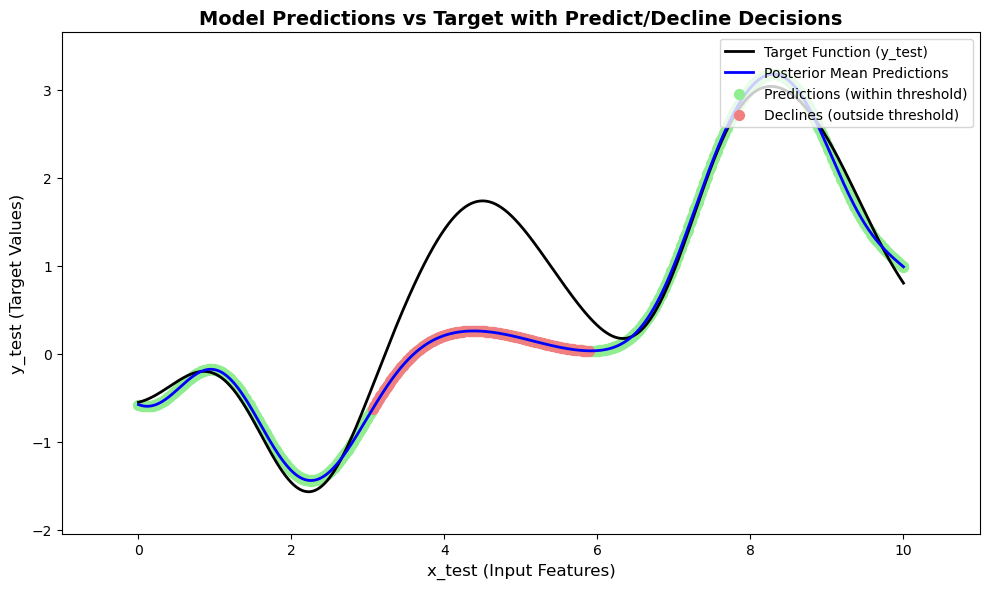

In [35]:
# Visualise your algorithm's decision-making (advanced / optional)

#### **** YOUR GRAPHING CODE HERE **** ####


# Create a mask for prediction and decline decisions
predict_mask = np.array([predict_or_decline(pred_var) == 'predict' for pred_var in predictive_variance])
decline_mask = ~predict_mask

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the target function (true values) as a line
plt.plot(x_test, y_test, label="Target Function (y_test)", color="black", lw=2)

# Plot the model's posterior mean predictions (as a line)
plt.plot(x_test, posterior_predictor, label="Posterior Mean Predictions", color="blue", linestyle="-", linewidth=2)

# Scatter plot for predictions (within threshold)
plt.scatter(x_test[predict_mask], posterior_predictor[predict_mask], color="lightgreen", label="Predictions (within threshold)", s=50)

# Scatter plot for declines (outside threshold)
plt.scatter(x_test[decline_mask], posterior_predictor[decline_mask], color="lightcoral", label="Declines (outside threshold)", s=50)

# Add labels, title, and legend
plt.xlabel("x_test (Input Features)", fontsize=12)
plt.ylabel("y_test (Target Values)", fontsize=12)
plt.title("Model Predictions vs Target with Predict/Decline Decisions", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="upper right")

# Ensure proper scaling of axes
plt.autoscale(enable=True, axis='both', tight=True)  # Automatically adjust axis limits
plt.margins(x=0.1, y=0.1)  # Add 10% padding to axes

# Adjust the layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

#
